## Importing Libraries

In [1]:
import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, callbacks
from sklearn.utils import class_weight

## Data Preprocessing

### Data Loading

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    batch_size=32,
    image_size=(224, 224),
    seed=123,
    shuffle=True,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'valid',
    batch_size=32,
    image_size=(224, 224),
    seed=42,
    shuffle=True,
)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


### Data Augmentation

In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), # Flip horizontal
    tf.keras.layers.RandomRotation(0.2), # Rotated by a random amount between -20% and +20% of a full circle
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)), # Zoom in/out by up to 20%
    tf.keras.layers.RandomContrast(factor=0.2) # Adjust contrast by up to 20%
])

## Model Building

In [4]:
# Get the class names as inferred by image_dataset_from_directory
class_names = train_ds.class_names
num_classes = len(class_names)

print("Number of classes:", num_classes)
print("\nClass names:", class_names)

print("\nCollecting all training labels for class weight calculation...")

all_training_labels = []
for images, labels in train_ds.unbatch():
    all_training_labels.append(labels.numpy())

all_training_labels_flat = np.array(all_training_labels).flatten()

unique_classes = np.arange(num_classes)
index_to_class_name = dict(zip(unique_classes, class_names))

sklearn_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=all_training_labels_flat
)

# Convert the array of weights to a dictionary mapping class index to weight
class_weights_dict = dict(enumerate(sklearn_class_weights))

Number of classes: 38

Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spott

### Fine-Tuning ResNet50

In [5]:
# Load the base ResNet50 model without top and without weights
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(224, 224, 3)
)

# Load local weights manually
base_model.load_weights("resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

base_model.trainable = False

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers on top of the base model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Model Training

In [6]:
early_stopping = callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

Epoch 1/10
2197/2197 [==============================] - 3158s 1s/step - loss: 2.4980 - accuracy: 0.3577 - val_loss: 1.1990 - val_accuracy: 0.7788
Epoch 2/10
2197/2197 [==============================] - 2903s 1s/step - loss: 1.1700 - accuracy: 0.6920 - val_loss: 0.6454 - val_accuracy: 0.8576
Epoch 3/10
2197/2197 [==============================] - 2997s 1s/step - loss: 0.7739 - accuracy: 0.7896 - val_loss: 0.4633 - val_accuracy: 0.8866
Epoch 4/10
2197/2197 [==============================] - 3013s 1s/step - loss: 0.5865 - accuracy: 0.8350 - val_loss: 0.3739 - val_accuracy: 0.9025
Epoch 5/10
2197/2197 [==============================] - 3002s 1s/step - loss: 0.4831 - accuracy: 0.8639 - val_loss: 0.3236 - val_accuracy: 0.9113
Epoch 6/10
2197/2197 [==============================] - 3024s 1s/step - loss: 0.4098 - accuracy: 0.8820 - val_loss: 0.2791 - val_accuracy: 0.9216
Epoch 7/10
2197/2197 [==============================] - 2919s 1s/step - loss: 0.3625 - accuracy: 0.8953 - val_loss: 0.2546 -

### Saving Model

In [8]:
model.save('plant_disease_model.keras')

In [9]:
import pickle

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [10]:
import json

with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

## Model Evaluation

In [11]:
# Model evaluation on training set
train_loss,train_acc = model.evaluate(train_ds)

2197/2197 [==============================] - 2243s 1s/step - loss: 0.1998 - accuracy: 0.9403


In [12]:
print(train_loss,train_acc)

0.19983501732349396 0.9402802586555481


In [13]:
# Model evaluation on validation set
val_loss,val_acc = model.evaluate(val_ds)

550/550 [==============================] - 709s 1s/step - loss: 0.2066 - accuracy: 0.9365


In [14]:
print(val_loss,val_acc)

0.2066270262002945 0.936546802520752


### Learning curves

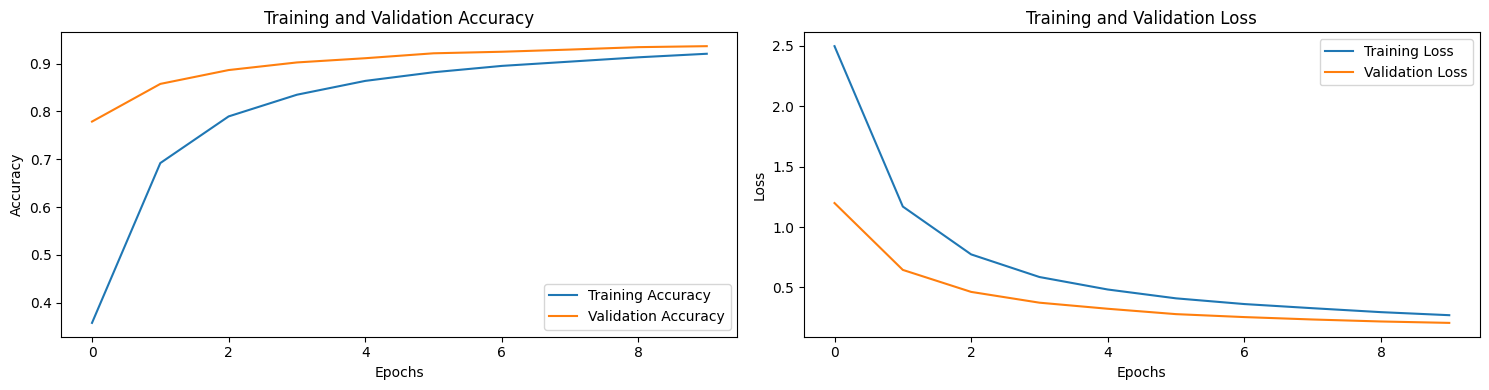

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Metrics

📊 Validation Evaluation Metrics:
Accuracy  : 0.9365
Precision : 0.9432
Recall    : 0.9365
F1-score  : 0.9370

🧾 Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.95      0.96      0.96       504
                                 Apple___Black_rot       0.98      0.97      0.98       497
                          Apple___Cedar_apple_rust       1.00      0.99      0.99       440
                                   Apple___healthy       0.94      0.98      0.96       502
                               Blueberry___healthy       0.98      1.00      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.95      0.98       421
                 Cherry_(including_sour)___healthy       0.99      0.99      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.83      0.89       410
                       Corn_(maize)_

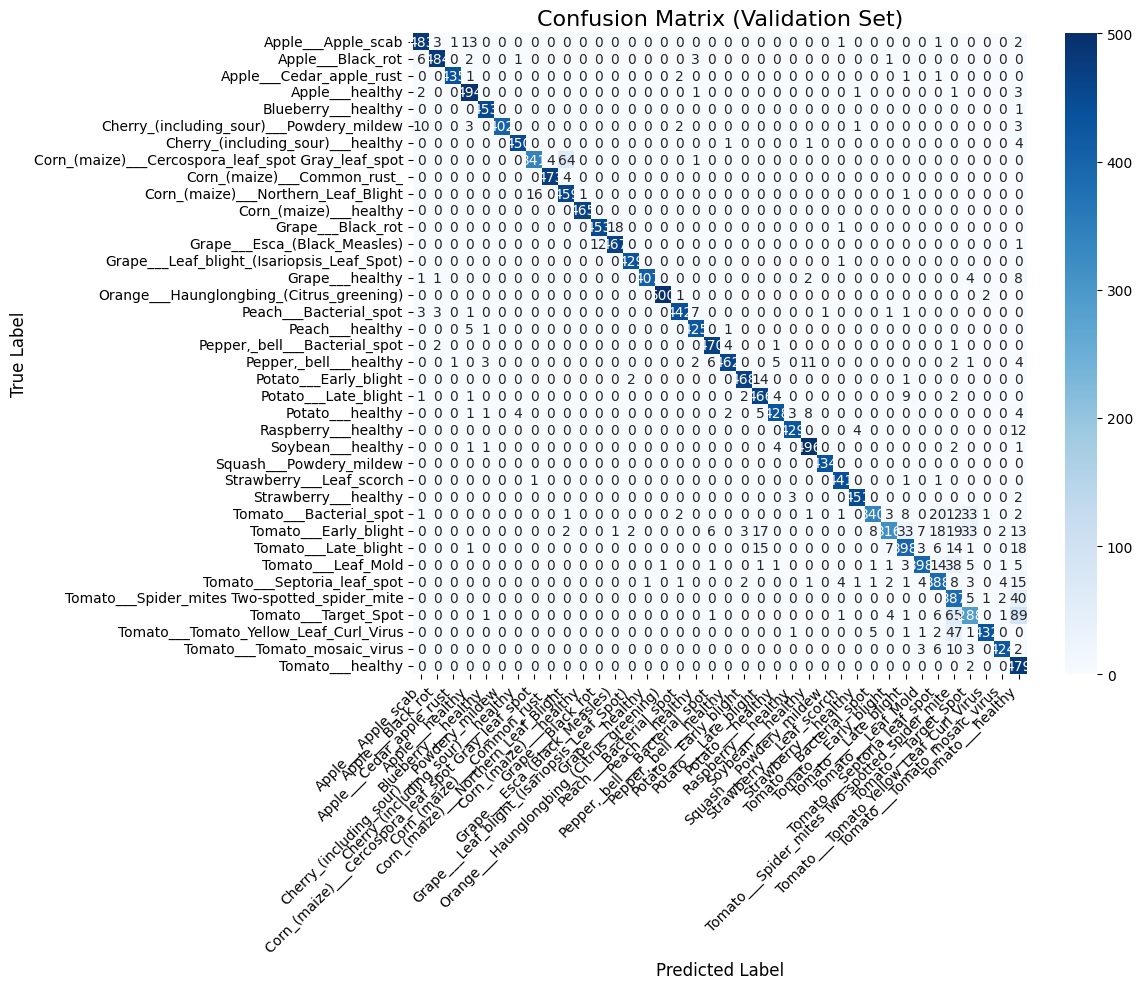

In [16]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Predict on validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print("📊 Validation Evaluation Metrics:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print()

# Classification report
print("🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation Set)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Predicting and Visualizing Test Images

In [27]:
# Load and preprocess a single image
def load_and_preprocess_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)
    return img_array

# Collect predictions and images
results = []
test_images_path = './test'

for filename in sorted(os.listdir(test_images_path)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(test_images_path, filename)
        img_array = load_and_preprocess_image(img_path)

        # Predict
        logits = model.predict(img_array, verbose=0)
        probs = tf.nn.softmax(logits, axis=-1).numpy()
        predicted_index = np.argmax(probs[0])
        confidence = probs[0][predicted_index]
        predicted_label = index_to_class_name[predicted_index]

        results.append({
            "filename": filename,
            "img_path": img_path,
            "label": predicted_label,
            "confidence": confidence
        })

# Plot a 5x5 grid of predictions
plt.figure(figsize=(20, 20))
for i, result in enumerate(results[:25]):
    plt.subplot(5, 5, i + 1)
    img = tf.keras.utils.load_img(result["img_path"], target_size=(224, 224))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    label_text = f"Actual: {result['filename']}\nPred: {result['label']} ({result['confidence'] * 100:.1f}%)"
    plt.xlabel(label_text, fontsize=10)

plt.suptitle("Top 25 Predictions on Test Set", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()